##### Name : Vaishnavi Ahir
##### PRN : 240340143001

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

from sklearn import datasets

import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision import transforms,datasets
from torchsummary import summary
from helper import fn_plot_torch_hist, fn_plot_confusion_matrix

In [2]:
###----------------------
### Some basic parameters
###----------------------

inpDir = '../../input' # location where input data is stored
outDir = '../output' # location to store outputs
subDir = 'cifar10' # location of the images
modelDir = '../models' # location to save model files
 # location related to this dataset
altName = 'pt_all_in' # Model file name for this alternative

RANDOM_STATE = 24 # for initialization ----- REMEMBER: to remove at the time of promotion to production

EPOCHS = 50   # number of cycles to run
ALPHA = 0.001
BATCH_SIZE = 32
TEST_SIZE = 0.2
IMG_HEIGHT = 32
IMG_WIDTH = 32

PATIENCE = 20

EPSILON = 1e-8 # min significant diff

## Early Stopping
ES_PATIENCE = 20 # if performance does not improve stop
# Learning rates
LR_PATIENCE = 10 # if performace is not improving reduce alpha
LR_FACTOR = 0.1 # rate of reduction of alpha


# Set parameters for decoration of plots
params = {'legend.fontsize' : 'large',
          'figure.figsize'  : (15,8),
          'axes.labelsize'  : 'x-large',
          'axes.titlesize'  :'x-large',
          'xtick.labelsize' :'large',
          'ytick.labelsize' :'large',
         }

CMAP = plt.cm.coolwarm

plt.rcParams.update(params) # update rcParams

### Prevent Tensorflow from hogging the memory

In [3]:
torch.cuda.is_available()

True

In [4]:
torch.version.cuda

'12.1'

In [5]:
torch.cuda.get_device_name(torch.cuda.current_device())

'NVIDIA GeForce RTX 2060 SUPER'

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [7]:
def fn_imshow(image,ax = None,title = None, normalize = True):     # in torch they take channel first.3*28*28

    if ax is None:
        fig,ax = plt.subplots()
    image = image.numpy().transpose((1,2,0))

    if normalize:

        mean = np.array([0.485,0.456,0.406])
        std = np.array([0.229,0.224,0.225])
        image = std*image + mean
        image = np.clip(image,0,1)

    ax.imshow(image)

    ### Beautification

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis = 'both',length = 0)

    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax

In [8]:
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize(mean = np.array([0.485,0.456,0.406]),std = np.array([0.229,0.224,0.225]))
                              ])

''' You can add as many data augmentation as you want'''



' You can add as many data augmentation as you want'

In [9]:
trainset = datasets.CIFAR10(root=inpDir, 
                            train=True,
                            download=True, 
                            transform=transform )
trainloader = torch.utils.data.DataLoader(trainset, 
                                          batch_size=BATCH_SIZE,
                                          shuffle=True,
                                          num_workers=8)

testset = datasets.CIFAR10(root=inpDir, 
                            train=False,
                            download=True, 
                            transform=transform )
testloader = torch.utils.data.DataLoader(testset, 
                                          batch_size=BATCH_SIZE,
                                          shuffle=True
                                          # num_workers=8)
                                         )

Files already downloaded and verified
Files already downloaded and verified


In [10]:
class_names = ['plane','car','bird','cat','deer',
              'dog','frog','horse', 'ship','truck']


In [11]:
# cols = data_df.columns
# for col in cols

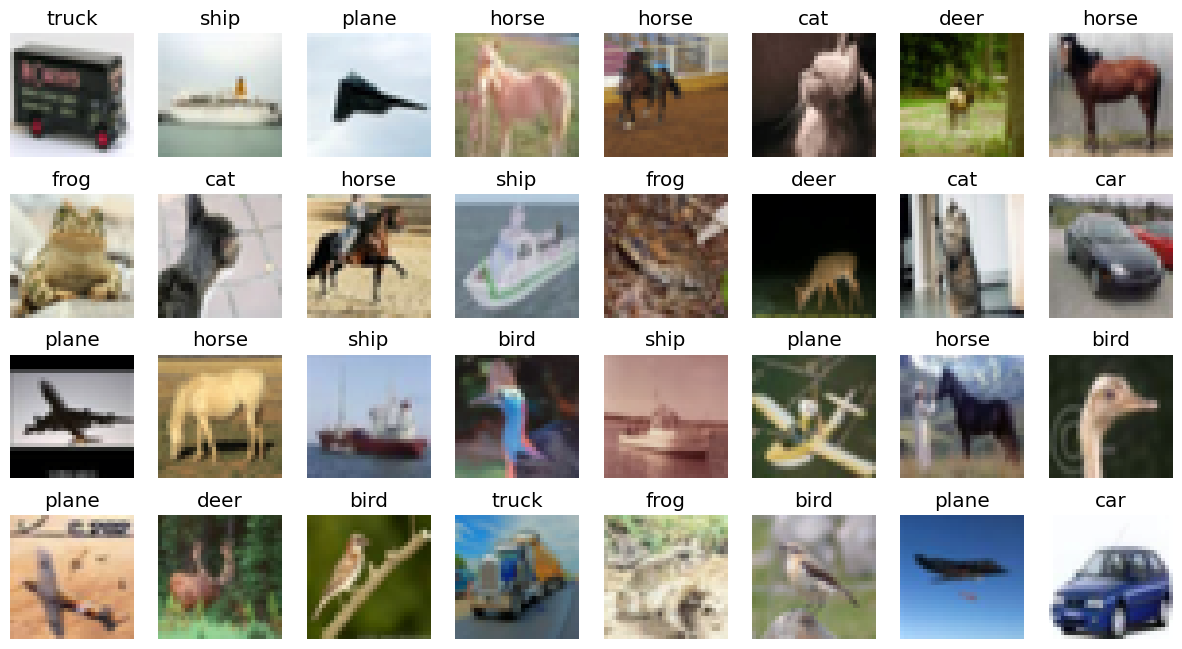

In [12]:
images, labels = next(iter(trainloader))
fig = plt.figure(figsize=(15,8))

for i in range(BATCH_SIZE):
    ax= fig.add_subplot(BATCH_SIZE//8,8, (i+1), xticks=[], yticks=[])
    fn_imshow(images[i], ax=ax, normalize=True)
    ax.set_title(class_names[labels[i]])

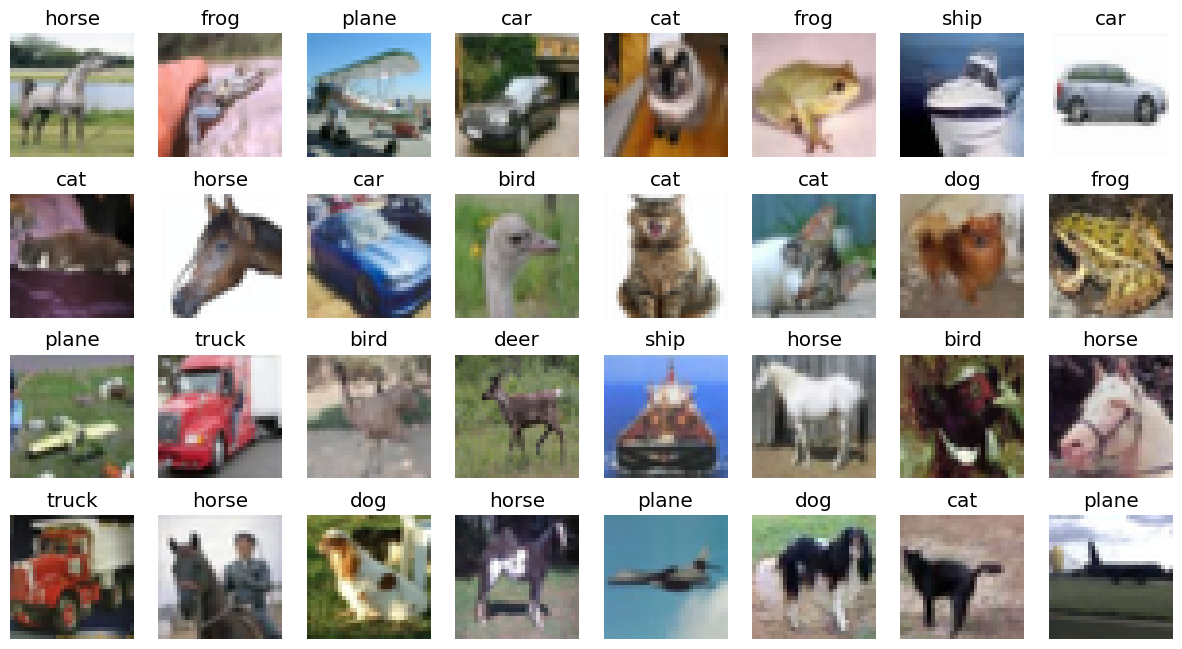

In [13]:
images, labels = next(iter(testloader))
fig = plt.figure(figsize=(15,8))

for i in range(BATCH_SIZE):
    ax= fig.add_subplot(BATCH_SIZE//8,8, (i+1), xticks=[], yticks=[])
    fn_imshow(images[i], ax=ax, normalize=True)
    ax.set_title(class_names[labels[i]])

In [14]:
trainloader.dataset

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ../../input
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=[0.485 0.456 0.406], std=[0.229 0.224 0.225])
           )

In [15]:
numChannels = 3  #hard coding

numClasses = len(class_names)

trainSteps = len(trainloader.dataset)// BATCH_SIZE

testSteps = len(testloader.dataset) // BATCH_SIZE

trainSteps,testSteps 


(1562, 312)

In [16]:

class LeNet(nn.Module):
    def __init__(self,numChannels,classes):
        #call parent's constructor
        super(LeNet, self).__init__()

        #Dropouts
        dor1 = 0.1
        dor2 = 0.15
        dor3 = 0.2
        dor4 = 0.2
        dor5 = 0.2
        #define Layers
        
#-------### set 01###-------------        
        out_channels1 = 32

        # Conv==> BN==>LeakyRelu==>Pool==>dropout
        self.conv1 = nn.Conv2d(in_channels = numChannels,out_channels = out_channels1,
                              padding = 'same',kernel_size = (3,3))   ## output_shape = 32 x 32 x 32

        self.bn1 = nn.BatchNorm2d(out_channels1)
        
        self.actv1 = nn.LeakyReLU()
        
        self.maxpool1= nn.MaxPool2d(kernel_size=(2,2),
                                    stride = (2,2))  ## output_shape = 16 x 16 x 32
        
        self.dropout1 = nn.Dropout(p=dor1)



#-------### set 02###-------------        
        out_channels2 = 64

        # Conv==> BN==>LeakyRelu==>Pool==>dropout
        self.conv2 = nn.Conv2d(in_channels = out_channels1,
                               out_channels = out_channels2,
                              padding = 'same',kernel_size = (3,3))   ## output_shape = 16 x 16 x 64

        self.bn2 = nn.BatchNorm2d(out_channels2)
        
        self.actv2 = nn.LeakyReLU()
        
        self.maxpool2= nn.MaxPool2d(kernel_size=(2,2),
                                    stride = (2,2))  ## output_shape = 8 x 8 x 64
        
        self.dropout2 = nn.Dropout(p=dor2)
        



#-------### set 03###-------------        
        out_channels3 = 128

        # Conv==> BN==>LeakyRelu==>Pool==>dropout
        self.conv3 = nn.Conv2d(in_channels = out_channels2,
                               out_channels = out_channels3,
                               kernel_size = (3,3))   ## output_shape = 6 x 6 x 128

        self.bn3 = nn.BatchNorm2d(out_channels3)
        
        self.actv3 = nn.LeakyReLU()
        
        self.maxpool3= nn.MaxPool2d(kernel_size=(2,2),
                                    stride = (2,2))  ## output_shape = 3 x 3 x 128
        
        self.dropout3 = nn.Dropout(p=dor3)



#-------### set 04###-------------        
        out_channels4 = 256

        # Conv==> BN==>LeakyRelu==>Pool==>dropout
        self.conv4 = nn.Conv2d(in_channels = out_channels3,
                               out_channels = out_channels4,
                               kernel_size = (3,3))   ## output_shape = 1 x 1 x 256

        self.bn4 = nn.BatchNorm2d(out_channels4)
        
        self.actv4 = nn.LeakyReLU()


#-------### Head###-------------        
        out_channels5 = 128   #256/2

        # Linear==> BN==>LeakyRelu==>Pool==>dropout
        self.fc1 = nn.Linear(in_features = 1 * 1 * out_channels4,         #fc-fully connected     
                               out_features = out_channels5
                               )   ## output_shape = 1 x 1 x 128
        self.bn5 = nn.BatchNorm1d(out_channels5)
        self.actv5 = nn.LeakyReLU()
        self.dropout5 = nn.Dropout(p=dor5)


#-----------final output layer----------
        self.fc2 = nn.Linear(in_features = 1 * 1 * out_channels5,            
                               out_features = classes)
                                  ## output_shape 128
        self.logsoftmax = nn.LogSoftmax(dim =1)



    def forward(self, x):
        #pass through 1
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.actv1(x)
        x= self.maxpool1(x)
        x = self.dropout1(x)

        #pass through 2
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.actv2(x)
        x= self.maxpool2(x)
        x = self.dropout2(x)

        #pass through 3
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.actv3(x)
        x= self.maxpool3(x)
        x = self.dropout3(x)

        #pass through 4
        x = self.conv4(x)
        x = self.bn4(x)
        x = self.actv4(x)

        x = torch.flatten(x,1)

        #Head Fully connected
        x = self.fc1(x)
        x = self.bn5(x)
        x = self.actv5(x)
        x = self.dropout5(x)

        #output
        x = self.fc2(x)
        return self.logsoftmax(x)
        
        

In [17]:
 # IMG(3X32X32) ==> (padding=same(conv(32X32X32)) ==> Max(16X16X32) ==> (padding=same(conv(16X16X64)) ==> Max(8X8) ==> conv(6X6) ==> Max(3X3) ==>conv (1X1) 

In [18]:
model = LeNet(numChannels=numChannels,classes=numClasses).to(device)

model = model.to(device)
print(model)

LeNet(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (actv1): LeakyReLU(negative_slope=0.01)
  (maxpool1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.1, inplace=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (actv2): LeakyReLU(negative_slope=0.01)
  (maxpool2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout(p=0.15, inplace=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (actv3): LeakyReLU(negative_slope=0.01)
  (maxpool3): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  

In [19]:
_ = summary(model,input_size = (3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
       BatchNorm2d-2           [-1, 32, 32, 32]              64
         LeakyReLU-3           [-1, 32, 32, 32]               0
         MaxPool2d-4           [-1, 32, 16, 16]               0
           Dropout-5           [-1, 32, 16, 16]               0
            Conv2d-6           [-1, 64, 16, 16]          18,496
       BatchNorm2d-7           [-1, 64, 16, 16]             128
         LeakyReLU-8           [-1, 64, 16, 16]               0
         MaxPool2d-9             [-1, 64, 8, 8]               0
          Dropout-10             [-1, 64, 8, 8]               0
           Conv2d-11            [-1, 128, 6, 6]          73,856
      BatchNorm2d-12            [-1, 128, 6, 6]             256
        LeakyReLU-13            [-1, 128, 6, 6]               0
        MaxPool2d-14            [-1, 12

In [20]:
print(f'Number of parameter: {len(list(model.parameters()))}')

Number of parameter: 22


In [21]:
opt = torch.optim.Adam(model.parameters(),lr = ALPHA)
loss_fn = nn.CrossEntropyLoss()
H = {
    'epoch':[],
    'train_loss': [],
    'test_loss': [],
    'train_acc': [],
    'test_acc': [],
}

In [22]:
minLoss = np.inf
counter = 0
savepath = os.path.join(outDir + '.pth')

In [24]:
for epoch in range(EPOCHS):
    model.train() # set ur model in train mode

    totalTrainLoss = 0
    totalTestLoss = 0
    trainCorrect = 0
    testCorrect = 0

    for (train_X,train_y) in trainloader:

        train_X = train_X.to(device)
        train_y = train_y.to(device)
        
        pred = model(train_X) # make prediction
    
        curr_loss = loss_fn(pred,train_y) # calculate loss
        
       ########################## 
       ### Back Propagation #####
       ##########################
        opt.zero_grad()
        curr_loss.backward()
        opt.step()
        totalTrainLoss += curr_loss
        
        trainCorrect += (pred.argmax(1) == train_y).type(torch.float).sum().item()
    

    with torch.no_grad():
        model.eval() # dont update weights

        for (test_X,test_y) in testloader:

            test_X = test_X.to(device)
            test_y = test_y.to(device)

            ts_pred = model(test_X)
            ts_curr_loss = loss_fn(ts_pred,test_y)

            totalTestLoss += ts_curr_loss
            testCorrect += (ts_pred.argmax(1) == test_y).type(torch.float).sum().item()

    avgTrainLoss = totalTrainLoss / trainSteps
    avgTestLoss = totalTestLoss / testSteps
    
#================== Add Early Stopping ========================#
    
    if avgTestLoss < minLoss:
        minLoss = avgTestLoss
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': opt.state_dict(),
            'loss': loss_fn,
            }, savepath)

    if avgTestLoss > minLoss:
        counter+=1

    if counter >= PATIENCE:
        break
#--------------------    

    trainCorrect = trainCorrect / len(trainloader.dataset)
    testCorrect = testCorrect / len(testloader.dataset)
        
    
    H['epoch'].append(epoch)
    H['train_loss'].append(avgTrainLoss.cpu().item())
    H['test_loss'].append(avgTestLoss.cpu().item())
    H['train_acc'].append(trainCorrect)
    H['test_acc'].append(testCorrect)

    print(f"[INFO] EPOCH : {epoch+1}/{EPOCHS}",end = ' ')
    print(f"Loss: {avgTrainLoss:.6f},Accuracy: {trainCorrect:.4f};",end = ' ') 
    print(f"Test Loss: {avgTestLoss:.6f},Test Accuracy: {testCorrect:.4f}") 


[INFO] EPOCH : 1/50 Loss: 0.960111,Accuracy: 0.6644; Test Loss: 0.810214,Test Accuracy: 0.7142
[INFO] EPOCH : 2/50 Loss: 0.838213,Accuracy: 0.7070; Test Loss: 0.698718,Test Accuracy: 0.7541
[INFO] EPOCH : 3/50 Loss: 0.761057,Accuracy: 0.7334; Test Loss: 0.671939,Test Accuracy: 0.7642
[INFO] EPOCH : 4/50 Loss: 0.699424,Accuracy: 0.7568; Test Loss: 0.632132,Test Accuracy: 0.7809
[INFO] EPOCH : 5/50 Loss: 0.648771,Accuracy: 0.7737; Test Loss: 0.594840,Test Accuracy: 0.7923
[INFO] EPOCH : 6/50 Loss: 0.604420,Accuracy: 0.7877; Test Loss: 0.589904,Test Accuracy: 0.7981
[INFO] EPOCH : 7/50 Loss: 0.575877,Accuracy: 0.7988; Test Loss: 0.576148,Test Accuracy: 0.8027
[INFO] EPOCH : 8/50 Loss: 0.544758,Accuracy: 0.8084; Test Loss: 0.583059,Test Accuracy: 0.7981
[INFO] EPOCH : 9/50 Loss: 0.514021,Accuracy: 0.8216; Test Loss: 0.541380,Test Accuracy: 0.8157
[INFO] EPOCH : 10/50 Loss: 0.492243,Accuracy: 0.8292; Test Loss: 0.541885,Test Accuracy: 0.8158
[INFO] EPOCH : 11/50 Loss: 0.463646,Accuracy: 0.8

In [25]:
loss_df = pd.DataFrame(H)
loss_df.head()

,epoch,train_loss,test_loss,train_acc,test_acc
0,0,0.960111,0.810214,0.66438,0.7142
1,1,0.838213,0.698718,0.70702,0.7541
2,2,0.761057,0.671939,0.73340,0.7642
3,3,0.699424,0.632132,0.75676,0.7809
4,4,0.648771,0.594840,0.77366,0.7923


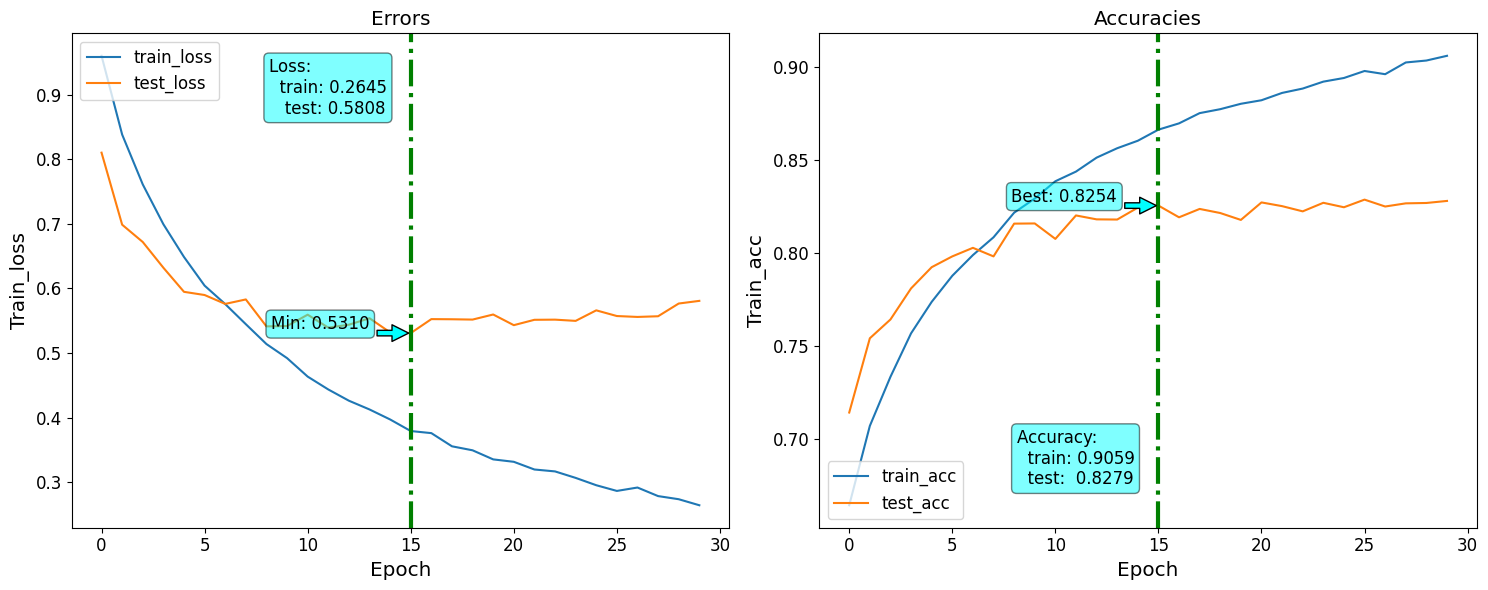

In [26]:
fn_plot_torch_hist(loss_df)

In [27]:
model_dict = torch.load(savepath)
model_dict.keys()

dict_keys(['epoch', 'model_state_dict', 'optimizer_state_dict', 'loss'])

In [37]:
model1 = LeNet(numChannels = numChannels, classes = numClasses).to(device)

model1.load_state_dict(model_dict['model_state_dict'])

<All keys matched successfully>

In [63]:
preds = []
labels = []
with torch.no_grad():
        model1.eval() # dont update weights

        for (test_X,test_y) in testloader:

            test_X = test_X.to(device)
            test_y = test_y.to(device)

            ts_pred = model1(test_X)
            preds.extend(ts_pred.argmax(axis=1).cpu().numpy())
            labels.extend(test_y.cpu().numpy())

            

In [64]:
accuracy_score(np.array(labels), np.array(preds))

0.8254

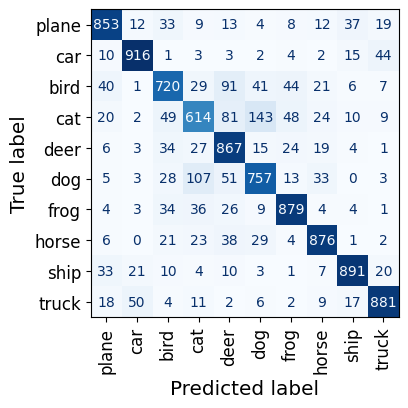

In [65]:
class_labels = {0:'plane',1:'car',2:'bird',3:'cat',4:'deer',
              5:'dog',6:'frog',7:'horse', 8:'ship',9:'truck'}

fn_plot_confusion_matrix(np.array(labels), np.array(preds), class_labels)

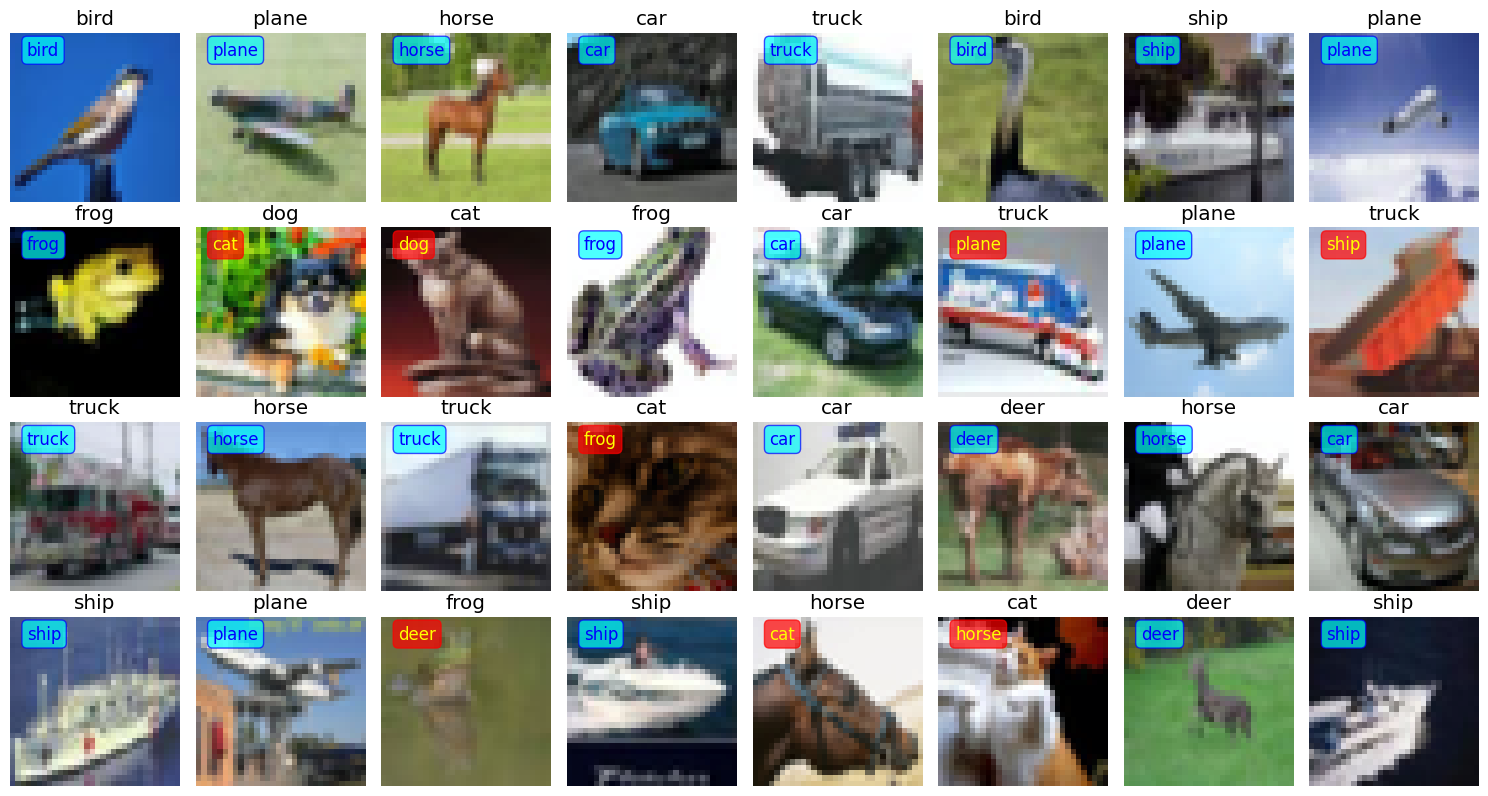

In [68]:
class_names = ['plane','car','bird','cat','deer',
              'dog','frog','horse', 'ship','truck']
# Run this to test ur data loader
images, labels = next(iter(testloader))

# predict again to keep y_pred in synch with the images
images = images.to(device)
yhat = model1(images)

y_pred = yhat.argmax(axis=1).cpu().detach().numpy()
labels=labels

# set fig size
fig = plt.figure(figsize=(15,8))

# adjust the sub
fig.subplots_adjust(left=0.,
                    right=1.,
                   bottom=0.,
                   top=1.,
                   hspace=0.05,
                   wspace=0.05)
fontsize = 12

for i in range(BATCH_SIZE):

    fc = 'cyan'
    ec = 'blue'
    text_color = 'blue'

    if labels[i]!= y_pred[i]:
        fc = 'red'
        ec = 'red'
        text_color = 'yellow'

    props = dict(boxstyle='round',facecolor = fc,alpha=0.7,ec =ec)
    
    ax= fig.add_subplot(BATCH_SIZE//8,8, (i+1), xticks=[], yticks=[]) # add a subplot to the figure
    
    fn_imshow(images[i].cpu(), ax=ax, normalize=True)
    
    ax.text(0.1,0.95,class_names[y_pred[i]],transform = ax.transAxes,
           fontsize =fontsize, color = text_color,
           verticalalignment = 'top',bbox = props)  # add number(class) of the image

    ax.set_title(class_names[labels[i]])

    ax.axis("off")

plt.tight_layout()

plt.show()